In [1]:
# Imports

# Algorithms:
from koebe.algorithms.incrementalConvexHull import incrConvexHull, orientationPointE3, randomConvexHullE3
from koebe.algorithms.hypPacker import *
from koebe.algorithms.sampling import surfaceSampling, boundarySampling
from koebe.algorithms.poissonDiskSampling import slowAmbientSurfaceSampling, slowAmbientBoundarySampling
from koebe.algorithms.cvt import weightedCVT, worldToImgPixelCoords
from koebe.algorithms.tutteEmbeddings import tutteEmbeddingE2

# Graphics:
from koebe.graphics.spherical2viewer import *
from koebe.graphics.euclidean2viewer import PoincareDiskViewer, makeStyle, E2Viewer

# Geometries:
from koebe.geometries.orientedProjective2 import DiskOP2
from koebe.geometries.euclidean3 import PointE3, VectorE3, SegmentE3
from koebe.geometries.euclidean2 import SegmentE2, PointE2, VectorE2
from koebe.geometries.commonOps import inner_product31

# Linear Algebra:
import numpy as np
from numpy.linalg import matrix_rank, norm
from scipy.linalg import null_space

# Image creation:
from PIL import Image, ImageDraw, ImageFilter

# Other:
import random

In [2]:
poly = randomConvexHullE3(6)
poly.outerFace = poly.faces[0]

tutteGraph = tutteEmbeddingE2(poly)

In [8]:
from koebe.graphics.euclidean2viewer import UnitScaleE2Sketch, makeStyle
viewer = UnitScaleE2Sketch()
#viewer.addAll([v.data for v in poly.verts])poly = randomConvexHullE3(16)

#for _ in range(60):
poly = randomConvexHullE3(16)
poly.outerFace = poly.faces[0]
tutteGraph = tutteEmbeddingE2(poly)
segments = [SegmentE2(e.aDart.origin.data, e.aDart.twin.origin.data) for e in tutteGraph.edges]
viewer.addAll(segments)
#viewer.pushAnimFrame()
#points = [v.data for v in tutteGraph.verts]
#viewer.addAll(points)

# for point in points:
#     viewer.setStyle(point, makeStyle(fill="#f00"))

for seg in segments:
    viewer.setStyle(seg, makeStyle(stroke="#000", strokeWeight=0.5))
viewer.show()

<IPython.core.display.Javascript object>

E2Sketch(height=500, objects='[[{"type": "SegmentE2", "endpoints": [[1.0, 0.0], [0.42557624346561823, 0.016928…

In [9]:
dists = [(v.data - PointE3.O).normSq() for v in tutteGraph.verts]
closestToOriginIdx = dists.index(min(dists))
packing, _ = maximalPacking(
    tutteGraph, 
    num_passes=1000, 
    centerDartIdx = tutteGraph.darts.index(tutteGraph.verts[closestToOriginIdx].aDart)
)
for i in range(len(packing.verts)):
    packing.verts[i].name = i

In [10]:
flipEdgeIdx = 10
flipEdge = packing.edges[flipEdgeIdx]

aIdx = flipEdge.aDart.origin.name
bIdx = flipEdge.aDart.dest.name
cIdx = flipEdge.aDart.prev.origin.name
dIdx = flipEdge.aDart.twin.prev.origin.name

# Run this to view the circle packing
viewer = E2Viewer(800, 800, scale = 1.0 / (4800*0.5-10))
blueStyle = makeStyle(stroke="#00f", strokeWeight=0.5)
redStyle = makeStyle(stroke="#f00", strokeWeight=2.5)
blueThickStyle = makeStyle(stroke="#00f", strokeWeight=2.5)
edgeSegs = [(SegmentE2(e.aDart.origin.data.toPoincareCircleE2().center, 
                      e.aDart.dest.data.toPoincareCircleE2().center), 
             blueStyle if e != flipEdge else redStyle)
            for e in packing.edges]
viewer.addAll([v for v in packing.verts])
viewer.addAll(edgeSegs)
viewer.setStyle(flipEdge.aDart.origin, redStyle)
viewer.setStyle(flipEdge.aDart.dest, redStyle)
viewer.setStyle(flipEdge.aDart.prev.origin, blueThickStyle)
viewer.setStyle(flipEdge.aDart.twin.prev.origin, blueThickStyle)
viewer.show()

<IPython.core.display.Javascript object>

E2Sketch(height=800, objects='[[{"type": "CircleE2", "center": [-0.3064907811271581, -0.4402640019747123], "ra…

In [11]:
verts31 = [DiskOP2.fromCircleE2(v.data.toPoincareCircleE2()).toDiskS2() 
           for v in packing.verts]
verts31 += [DiskS2(0,0,0,0)] # Add in the origin.

# Labeling each vertex with its index in the vertex list is
# useful for building the rigidity matrix
for i in range(len(packing.verts)):
    packing.verts[i].name = i

edgeList = [(e.aDart.origin.name, e.aDart.dest.name) for e in packing.edges]
edgeList += [(vIdx, len(verts31) - 1) for vIdx in range(len(verts31) - 1)]

# Build the rigidity matrix. 
def edgeRow(edgeIdx, disks, edgeList):
    i, j = edgeList[edgeIdx]
    pi = tuple(disks[i])
    pj = tuple(disks[j])
    cij = [pj[0] - pi[0], pj[1] - pi[1], pj[2] - pi[2], pi[3] - pj[3]]
    cji = [pi[0] - pj[0], pi[1] - pj[1], pi[2] - pj[2], pj[3] - pi[3]]
    return np.array([
        cij if vIdx == i else
        cji if vIdx == j else
        [0,0,0,0]
        for vIdx in range(len(disks) - 1)
    ]).flatten()

def vertexPin(vIdx, disks):
    r1 = np.array([[1, 0, 0, 0] if i == vIdx else [0, 0, 0, 0] 
                   for i in range(len(disks) - 1)]).flatten()
    r2 = np.array([[0, 1, 0, 0] if i == vIdx else [0, 0, 0, 0] 
                   for i in range(len(disks) - 1)]).flatten()
    r3 = np.array([[0, 0, 1, 0] if i == vIdx else [0, 0, 0, 0] 
                   for i in range(len(disks) - 1)]).flatten()
    r4 = np.array([[0, 0, 0, 1] if i == vIdx else [0, 0, 0, 0] 
                   for i in range(len(disks) - 1)]).flatten()
    return np.array([r1, r2, r3, r4])

def rigidityMatrix(disks, edgeList, pinSet = None):
    edgeRows = np.array([
        edgeRow(eIdx, disks, edgeList) 
        for eIdx in range(len(edgeList)) if eIdx != flipEdgeIdx
    ])
    if pinSet is None:
        pinSet = [0, 1, 2]
    pinRows0    = vertexPin(pinSet[0], disks)
    pinRows1    = vertexPin(pinSet[1], disks)
    pinRows2    = vertexPin(pinSet[2], disks)
    pinRowsOrig = vertexPin(len(disks) - 1, disks)
    return np.concatenate((edgeRows, pinRows0, pinRows1, pinRows2, pinRowsOrig))

In [12]:
def newtonStepOneDisk(disk, ns, deltaT):
    a = disk.a + deltaT * ns[0]
    b = disk.b + deltaT * ns[1]
    c = disk.c + deltaT * ns[2]
    d = disk.d + deltaT * ns[3]
    inv31 = 1.0# / inner_product31(a, b, c, d, a, b, c, d)
    return DiskS2(a * inv31, b * inv31, c * inv31, d * inv31)

def newtonStep(disks, edgeList, deltaT, prevNs, pinSet = None, direction = 1):
    R = rigidityMatrix(disks, edgeList, pinSet)
    ns = null_space(R).reshape(len(disks)-1, 4)
    if prevNs is not None:
        posDot = np.dot(np.transpose(ns.reshape(64, 1)), prevNs.reshape(64, 1))[0][0]
        negDot = np.dot(np.transpose((-ns).reshape(64, 1)), prevNs.reshape(64, 1))[0][0]
        if negDot > posDot:
            ns = -ns
    else:
        ns = ns * direction
    return [newtonStepOneDisk(disks[vIdx], ns[vIdx], deltaT) 
            for vIdx in range(len(disks) - 1)] + [disks[-1]], ns

def newtonAnimation(initialDisks, edgeList, iterationCount, deltaT, pinSet = None, direction = 1):
    animation = [initialDisks]
    prevNs = None
    for _ in range(iterationCount):
        nextFrame, prevNs = newtonStep(animation[-1], edgeList, deltaT, prevNs, pinSet, direction)
        animation.append(nextFrame)
    return animation

In [13]:
anim = newtonAnimation(verts31, edgeList, 1600,0.02, pinSet = [0,1,2], direction = 1)


In [15]:


# Run this to view the circle packing
viewer = E2Viewer(800, 800, scale = 1/400)
viewer.addAll([v.sgProjectToOP2() for v in verts31[0:len(verts31)-1]])

viewer.pushAnimFrame()

for i in range(800):#len(anim)):
    disksForward = [(d.sgProjectToOP2(), blueStyle) 
            for d in anim[i][:-1]]
    viewer.pushAnimFrame()
    viewer.addAll(disksForward)

# disksForward = [(d.sgProjectToOP2(), blueStyle) 
#             for d in anim[1][:-1]]
# viewer.addAll(disksForward)

viewer.show()
print(verts31[0])

<IPython.core.display.Javascript object>

E2Sketch(height=800, objects='[[{"type": "CircleE2", "center": [0.549936480036191, 0.5223008438824318], "radiu…

DiskS2(a=0.927117918220786, b=0.8805280039494247, c=0.6129815622543162, d=-1.072882081779214)


In [16]:
# Run this to view the circle packing
viewer = S2Viewer(800, 800)

invDists = []

diskSet = [v for v in verts31[0:len(verts31)-1]]
viewer.addAll(diskSet)
for d in diskSet:
    viewer.setStyle(d, blueStyle)
    
n = 95
redStyle = makeStyle(stroke = "#f00", strokeWeight = 0.5)
for i in range(n):#len(anim)):
    disksForward = [d for d in anim[i][:-1]]
    orthos = [CPlaneS2.throughThreeDiskS2(*[disksForward[v.name] 
                                            for v in f.vertices()]) 
              for f in packing.faces]
    viewer.pushAnimFrame()
    viewer.addAll(disksForward)
    #viewer.addAll(orthos)
    for d in disksForward:
        viewer.setStyle(d, blueStyle)
    for o in orthos:
        viewer.setStyle(o, redStyle)
    viewer.setStyle(disksForward[aIdx], redStyle)
    viewer.setStyle(disksForward[bIdx], redStyle)
    viewer.setStyle(disksForward[cIdx], redStyle)
    viewer.setStyle(disksForward[dIdx], redStyle)
    invDists.append((disksForward[aIdx].inversiveDistTo(disksForward[bIdx]), 
                     disksForward[cIdx].inversiveDistTo(disksForward[dIdx])))
        

for i in range(n):#len(anim)):
    disksForward = [d for d in anim[n - i - 1][:-1]]
    orthos = [CPlaneS2.throughThreeDiskS2(*[disksForward[v.name] 
                                            for v in f.vertices()]) 
              for f in packing.faces]
    viewer.pushAnimFrame()
    viewer.addAll(disksForward)
    #viewer.addAll(orthos)
    for d in disksForward:
        viewer.setStyle(d, blueStyle)
    for o in orthos:
        viewer.setStyle(o, redStyle)
    viewer.setStyle(disksForward[aIdx], redStyle)
    viewer.setStyle(disksForward[bIdx], redStyle)
    viewer.setStyle(disksForward[cIdx], redStyle)
    viewer.setStyle(disksForward[dIdx], redStyle)


<IPython.core.display.Javascript object>

In [17]:

viewer.show()

S2Sketch(height=800, objects='[[{"type": "DiskS2", "disk": [0.927117918220786, 0.8805280039494247, 0.612981562…

In [129]:
invDists
[math.acosh(invDists[i][0]) + math.acosh(invDists[i][1]) for i in range(len(invDists))]

[2.1831099235640687,
 2.4876939422859565,
 2.604717337898131,
 2.690727578297574,
 2.7606235006487894,
 2.820183255501733,
 2.8723736315147583,
 2.918958921145422,
 2.961089795019563,
 2.9995662312156535,
 3.0349711553851337,
 3.0677449324160104,
 3.098229874497455,
 3.126698319146513,
 3.1533711345833026,
 3.1784303636014544,
 3.202028127603155,
 3.2242930603376068,
 3.2453350608656053,
 3.2652488732484395,
 3.2841168286881333,
 3.3020109778385827,
 3.3189947712465995,
 3.335124399657027,
 3.3504498746399314,
 3.3650159084159217,
 3.3788626365754135,
 3.392026216561368,
 3.4045393269509105,
 3.4164315867782573,
 3.427729909889124,
 3.4384588060834282,
 3.448640638338836,
 3.4582958435502476,
 3.467443122754347,
 3.4760996056680886,
 3.4842809934783823,
 3.492001683100277,
 3.499274875568547,
 3.5061126707438692,
 3.51252615016695,
 3.5185254495812295,
 3.524119822375763,
 3.529317695031655,
 3.534126715454083,
 3.538553794921463,
 3.5426051442901043,
 3.546286304963428,
 3.54960217503

# Question on 4-gon flexibility

If we have a circle 4-gon with one tangency and all else disjoint does the flow always create another tangency?

In [130]:
# Run this to view the circle packing
construction = S2Viewer(800, 800)

x  = PointS2(1, 0, 0)
y  = PointS2(0, 1, 0)
z  = PointS2(0, 0, 1)

p1 = PointS2(1, -0.5, 0)
p2 = PointS2(1, 0.5, 0)
p3 = PointS2(0, 1, 0)
p4 = PointS2(0.5, 0.3, 0.7)
p5 = PointS2(0, 1, 1)

A = DiskS2.withDiameterS2(p1, p2)
B = DiskS2.withDiameterS2(p2, p3)
C = DiskS2.withCenterAndRadiusS2(p4, math.pi/16)
D = DiskS2.withCenterAndRadiusS2(p5, math.pi/18)

construction.setStyle(C, redStyle)
construction.setStyle(D, blueStyle)

construction.addAll([p1, p2, p3, p4, p5, A, B, C, D])
construction.show()

<IPython.core.display.Javascript object>

NameError: name 'p1S2' is not defined

In [87]:
DiskS2.withCenterAndRadiusS2 = withCenterAndRadiusS2

In [106]:

aIdx = flipEdge.aDart.origin.name
bIdx = flipEdge.aDart.dest.name
cIdx = flipEdge.aDart.prev.origin.name
dIdx = flipEdge.aDart.twin.prev.origin.name

In [120]:
from matplotlib.pyplot import plot

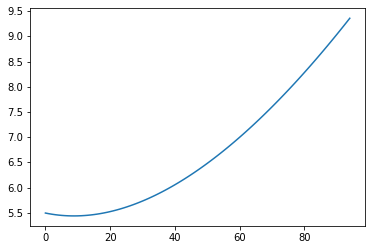

In [132]:
ys = [invDists[i][0] + invDists[i][1] for i in range(len(invDists))]
xs = [i for i in range(len(invDists))]

plot(xs, ys)